# Lens Modeling for DESIJ1539+1650

**Authors:** Zannat Chowdhury, Anowar J. Shajib\
**Acknowledgements:** S M Rafee Adnan, Akbar

#### Importing the required packages

In [1]:
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


#### Read the data file

In [2]:
with h5py.File("DESIJ1539+1650_F140W.h5", "r") as f:
    kwargs_data = {}

    for key in f:
        if key == "exposure_time":
            kwargs_data[key] = f[key][()]
            continue
        kwargs_data[key] = f[key][()]

# print kwargs_data
for key in kwargs_data:
    print(f"{key}: {kwargs_data[key]}")

background_rms: 0.013182383426603758
dec_at_xy_0: -9.23999999999999
exposure_time: [[490.90875 421.75388 439.10574 ... 486.56738 406.6674  548.1046 ]
 [447.409   503.6679  418.47308 ... 592.03424 454.74384 466.78656]
 [441.13593 567.0645  418.47824 ... 464.80774 433.77225 425.30106]
 ...
 [604.4732  476.06665 545.15735 ... 528.9927  497.26175 367.77853]
 [490.31616 330.20276 396.50378 ... 341.58386 422.0971  425.519  ]
 [451.5098  483.99115 520.6441  ... 475.88297 564.95496 522.05316]]
image_data: [[ 0.00067712 -0.01423318  0.00151635 ... -0.00029543 -0.00692246
  -0.0166516 ]
 [ 0.00363533 -0.00039791 -0.01873723 ...  0.01981123  0.00081102
   0.00612396]
 [-0.01712817 -0.00955698 -0.0194798  ...  0.00040743 -0.00297122
  -0.00672446]
 ...
 [ 0.00515814  0.00832129 -0.00283378 ... -0.00238547  0.00146614
  -0.00219803]
 [-0.00667532  0.00798152  0.00278799 ...  0.00431538  0.00754044
  -0.00536348]
 [-0.00077069  0.0147179   0.00402649 ... -0.00141456 -0.0080586
   0.00624329]]
ra_at_

#### Load PSF data


In [3]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}

    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
print(kwargs_psf)

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
        3.2385867e-06, 4.4331632e-06],
       [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
        6.6143798e-06, 4.1430776e-06],
       [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
        5.1404800e-06, 1.7530243e-06],
       ...,
       [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
        5.3933368e-06, 1.6360833e-06],
       [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
        8.7221979e-06, 3.7005334e-06],
       [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
        3.2246478e-06, 5.1252514e-06]], dtype=float32), 'psf_type': 'PIXEL'}


#### Get the image data from `kwargs_data` and plot it

/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_41266/1502520930.py:3: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


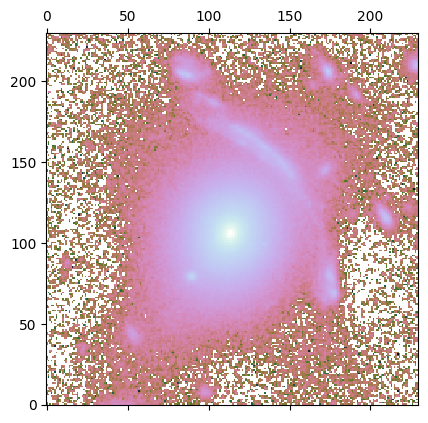

In [4]:
image_data = kwargs_data["image_data"]

plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.show()

#### Make mask and plot it

/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_41266/2146928540.py:62: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_41266/2146928540.py:73: RuntimeWarning: divide by zero encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
/var/folders/4r/4s5vv2m95cn1thyzpqql8pp80000gn/T/ipykernel_41266/2146928540.py:73: RuntimeWarning: invalid value encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


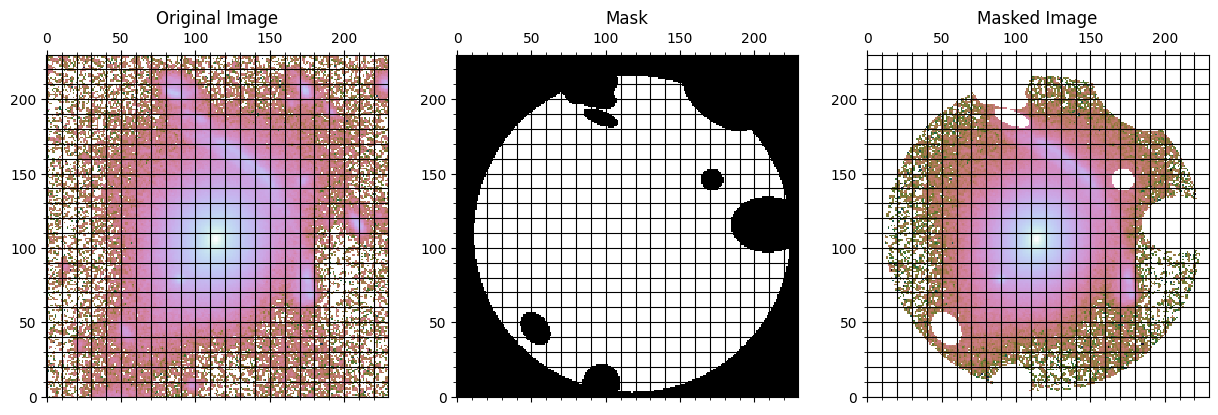

In [5]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 8.5  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra - 0.2,
    lens_center_dec - 0.5,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_params = [
    [-7.5, 0, 2, 1.5, -np.pi / 180 * 0],  # x, y, q, phi, theta
    [-5, 7, 1.5, 2.5, -np.pi / 180 * 50],
    [-4.5, 2.4, 0.6, 0.6, 0],
    [2.5, 7.35, 2, 0.8, np.pi / 180 * 25],
    [2, 7.35, 1.5, 0.8, -np.pi / 180 * 20],
    [1.45, -8.5, 1, 1, 0],
    # [5.5, -9, 3.5, 1, 0],
    [1.5, 5.75, 0.4, 1, -np.pi / 180 * 68],  # 11 O'clock Arc Left hand thin slice
    [
        5,
        -5.6,
        0.7,
        1,
        -np.pi / 180 * 35,
    ],  # probable lense galaxy fuzzy blob counter image of arc
    # [2, -3, 0.5, 0.5, np.pi / 2], #lense galaxy small bright blob
    # [-1.75, 5, 2.8, 2, np.pi / 4],
]

mask = 1 - mask_outer

for mask_param in mask_params:
    mask *= 1 - mask_util.mask_ellipse(
        util.image2array(x_coords),
        util.image2array(y_coords),
        mask_param[0],
        mask_param[1],
        mask_param[2],
        mask_param[3],
        mask_param[4],
    )

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

# mask image data
masked_image_data = np.multiply(image_data, mask)

# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
ax1.grid(which="both", color="black")
ax1.minorticks_on()
ax1.grid(which="minor", color="black")
ax1.title.set_text("Original Image")
ax2.matshow(mask, origin="lower", cmap="cubehelix")
ax2.grid(which="both", color="black")
ax2.minorticks_on()
ax2.grid(which="minor", color="black")
ax2.title.set_text("Mask")
ax2.title.set_text("Mask")
ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
ax3.grid(which="both", color="black")
ax3.minorticks_on()
ax3.grid(which="minor", color="black")
ax3.title.set_text("Masked Image")
plt.show()

## Lens Modeling with Lenstronomy

In [6]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens Galaxy's Mass Model

### EPL Parameters

In [7]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({"gamma": 2})
kwargs_lens_init.append(
    {
        "theta_E": 3.4,  ##einstein ring distance in arcseconds
        "gamma": 2,  ##if greater than 2, mass density falls quickly with distance
        "e1": 0,  ##0
        "e2": 0,  ##0
        "center_x": -0.04,
        "center_y": -0.3,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.5,  ##0.5
        "gamma": 0.3,  ##0.3
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 3,
        "gamma": 1.7,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3,  ##3
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

### Shear Parameters

In [8]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append({"gamma1": 0, "gamma2": 0})  ##0, 0
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source Galaxy's Light Model

### Sersic Ellipse Parameters

In [9]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 1,
        "e1": 0,
        "e2": 0,
        "center_x": 0,
        "center_y": 0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -20,
        "center_y": -20,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 1,  ##last value 0.2, reason for change - light needs more spreadout from center
        "n_sersic": 5.0,
        "center_x": 10,  # 20
        "center_y": 10,  # 20
        "amp": 10,
    }
)

### Shapelets Parameters

In [10]:
fixed_source.append({"n_max": 8})
kwargs_source_init.append(
    {"center_x": 0, "center_y": 0, "beta": 0.001}
)  ##0, 0, 0.001 beta -> more beta = freedom of source light taking more complex form
kwargs_source_sigma.append(
    {"center_x": 0.2, "center_y": 0.2, "beta": 0.05}
)  # last beta value 0.001, reason for change - arc recreation not proper
kwargs_lower_source.append({"center_x": -20, "center_y": -20, "beta": 0.001})
kwargs_upper_source.append(
    {"center_x": 20, "center_y": 20, "beta": 0.2}
)  # last beta value 0.05, reason for change - arc recreation not proper

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

## Lens Galaxy's Light Model

### 1st Sersic Ellipse Parameters

In [11]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.005,  # 1
        "n_sersic": 1,  # 1
        "e1": 0.05,  # 0
        "e2": 0.1,  # 0
        "center_x": 0.15,  # 0
        "center_y": -0.5,  # 0
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.0001,  # 0.5
        "e1": 0.01,  # 0.05
        "e2": 0.05,
        "center_x": 0.01,  # 0.2
        "center_y": 0.01,  # 0.2
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 10,
    }
)

joint_lens_with_light = [[0, 0, ["center_x", "center_y"]]]  #

### 2nd Sersic Ellipse Parameters

In [12]:
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 2,
        "n_sersic": 4,
        "e1": -0.1,  # 0.
        "e2": -0.1,  # 0.
        "center_x": 0.15,  # 0.
        "center_y": -0.8,  # 0.
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.1,  # 0.5
        "e1": 0.01,  # 0.05
        "e2": 0.05,  # 0.05
        "center_x": 0.01,  # 0.2
        "center_y": 0.01,  # 0.2
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 10,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [13]:
# Combining all the above specification in the `kwargs_params` dictionary

kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
    "joint_lens_with_light": joint_lens_with_light,  # newly added forcing lens center to match with light
}

In [14]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [15]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band
    # has independent solutions of the
    # surface brightness, 'joint-linear':
    # there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## The Model Fitting

In [16]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    [
        "PSO",
        {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 500},
    ]  ##iteration: 400 would work
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
Converged after 315 iterations!
Best fit found:  -40260.865681241274 [3.504375219754954, -0.09239362452971149, -0.01900197778656138, -0.16926003387995858, 0.299999488491994, 0.006510539954774476, 0.03160130879732656, 0.1471679907837618, -1.5300589808212641, 0.16621321996729338, 0.19999999285434486, 0.0037243614358179497, 0.07297669665617038, -0.1389833842794424, 0.14815630877066427, -0.7763926700551133, 1.6069934846187774, -0.07033086319712768, -0.08090074846306776]
-2.5148109360842796 reduced X^2 of best position
-40260.865681241274 log likelihood
32019 effective number of data points
[{'theta_E': 3.504375219754954, 'gamma': 2, 'e1': -0.09239362452971149, 'e2': -0.01900197778656138, 'center_x': 0.14815630877066427, 'center_y': -0.7763926700551133}, {'gamma1': -0.16926003387995858, 'gamma2': 0.299999488491994, 'ra_0': 0, 'dec_0': 0}] lens result
[{'am

In [17]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1539+1650_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the Fitted Model

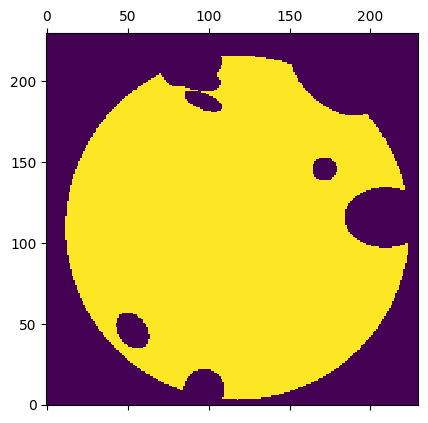

In [18]:
plt.matshow(kwargs_likelihood["image_likelihood_mask_list"][0], origin="lower")

-2.50955966333768 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.5095596633376784


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_pl

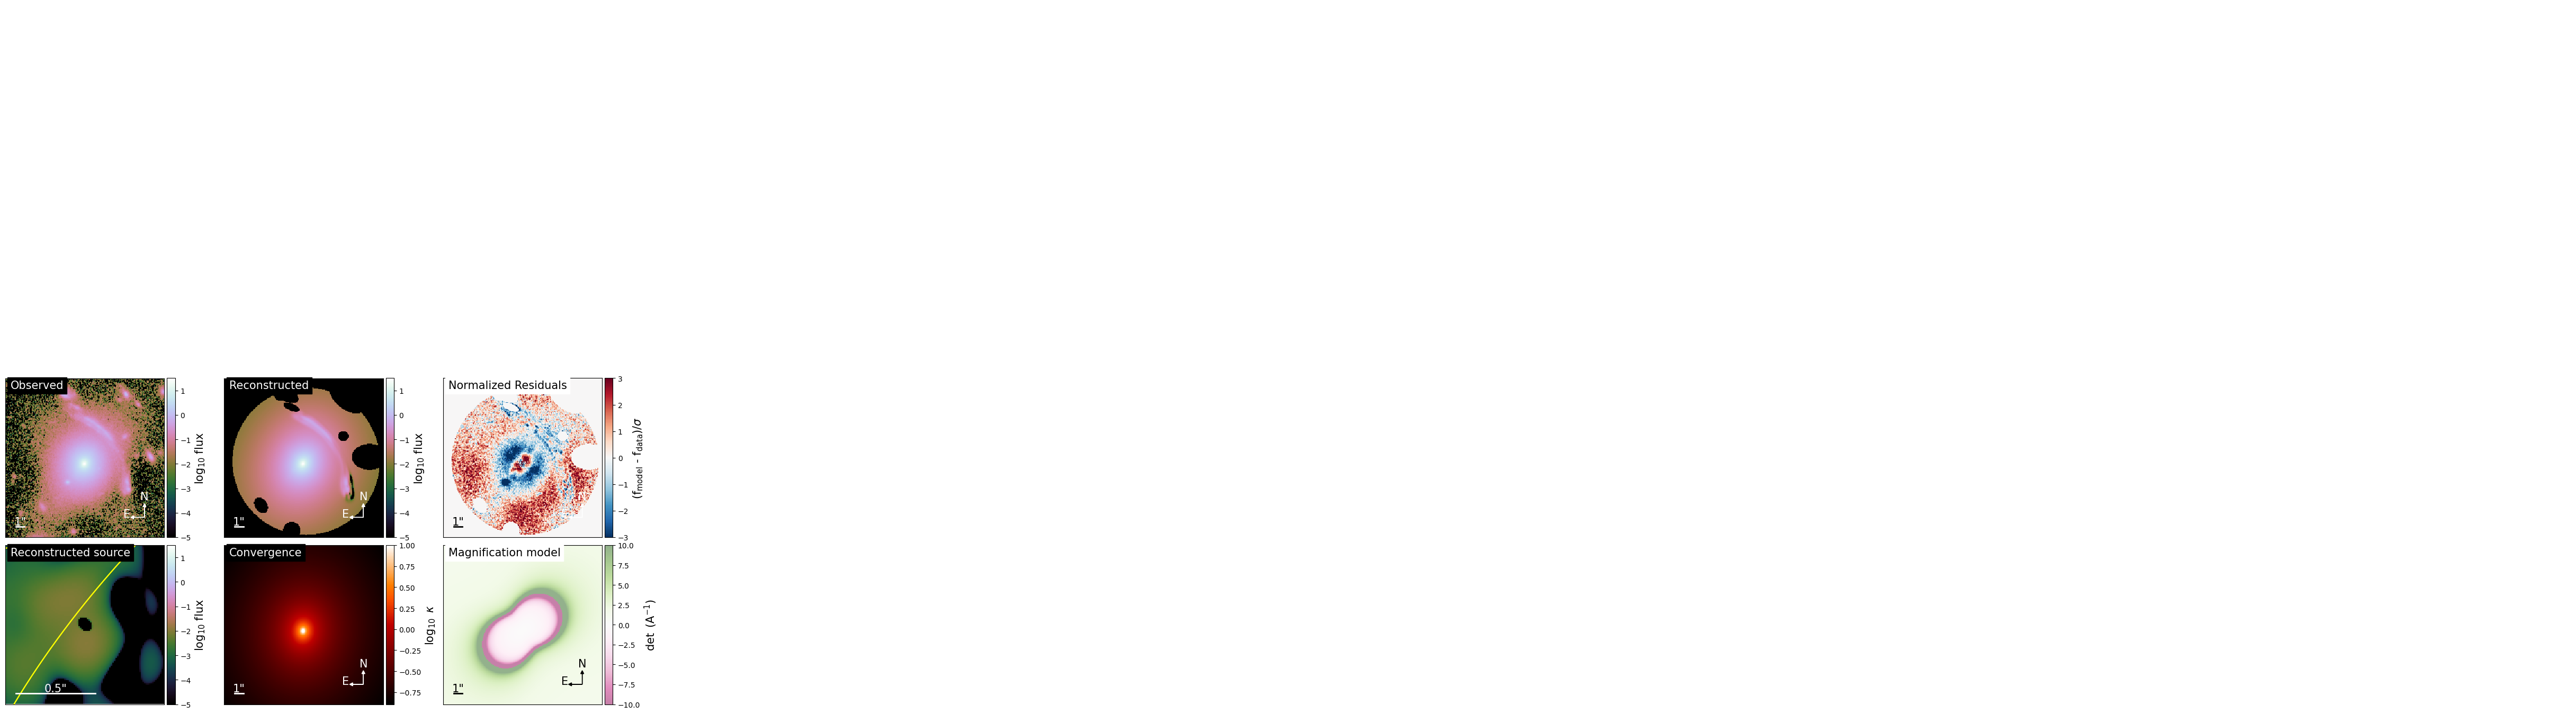

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


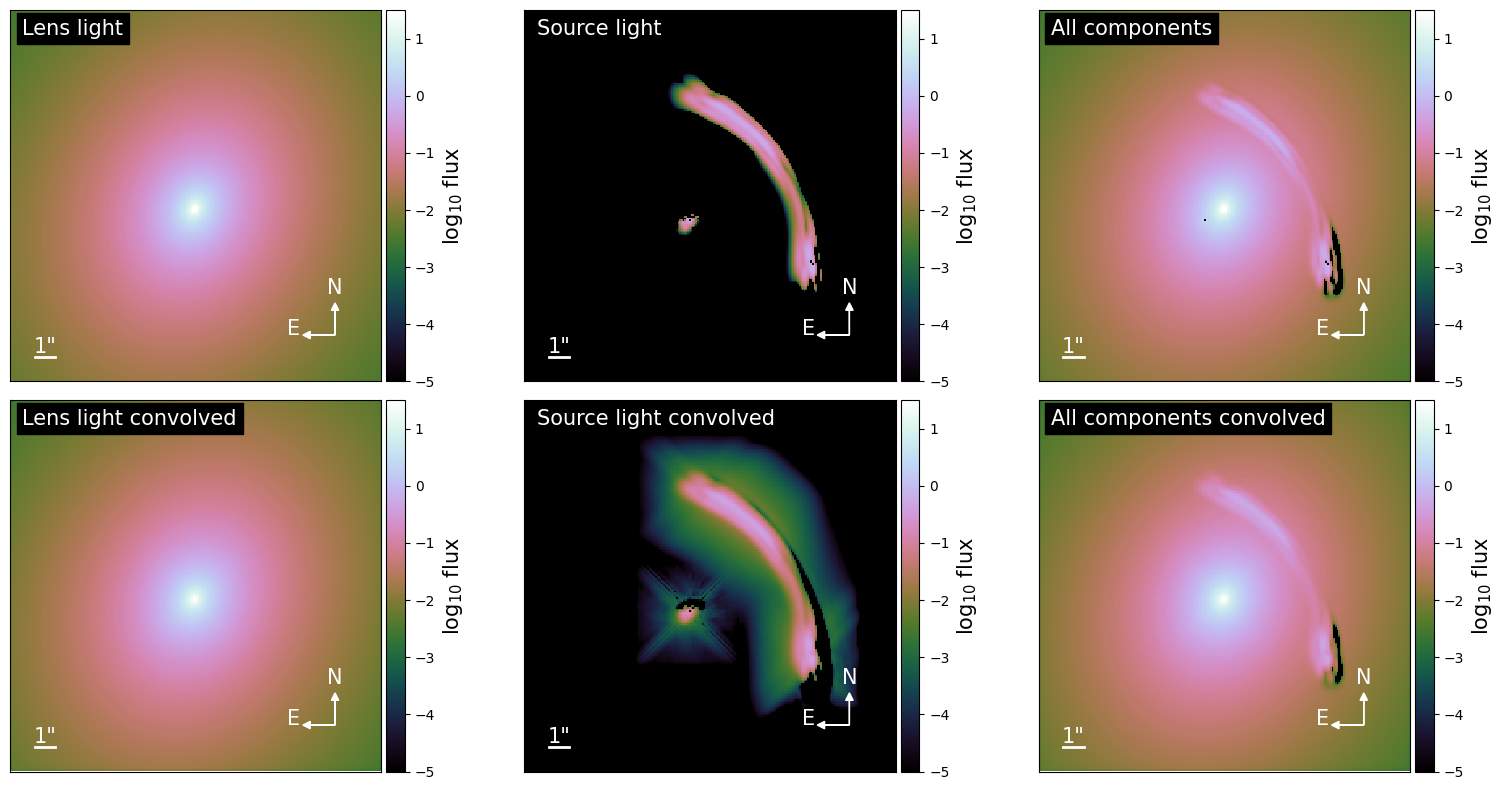

{'kwargs_lens': [{'theta_E': 3.504375219754954, 'gamma': 2, 'e1': -0.09239362452971149, 'e2': -0.01900197778656138, 'center_x': 0.14815630877066427, 'center_y': -0.7763926700551133}, {'gamma1': -0.16926003387995858, 'gamma2': 0.299999488491994, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -462227.98092730605, 'R_sersic': 0.006510539954774476, 'n_sersic': 1.0, 'e1': 0.03160130879732656, 'e2': 0.1471679907837618, 'center_x': -1.5300589808212641, 'center_y': 0.16621321996729338}, {'amp': array([151.40306853,  73.52290171,   5.08794551,  -6.59826628,
        15.05064936,  10.1905835 ,  22.56941625,   1.27939195,
        11.57970147,  19.80632403,  28.24036398, -13.65739044,
         8.71789186, -15.16008518, -14.51941376,  18.52914477,
       -14.68685829,  20.43804487,  -5.15782238, -11.61800195,
        -2.83576389,  -4.71434444,   7.11137123,   6.69554355,
         4.50968941,   3.42300176,   9.25562667,  10.83467624,
        25.71869611,   7.75186708,   7.51785527,  -4.08897933,


In [19]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)